In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/123456/PEMS04.csv
/kaggle/input/1478963/PEMS04.csv
/kaggle/input/1478963/PEMS04.npz
/kaggle/input/1478963/pems08.npz
/kaggle/input/1478963/PEMS08.csv
/kaggle/input/pems123/PEMS04.npz
/kaggle/input/pems123/pems08.npz


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import random
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from datetime import datetime, timedelta


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Spatial attention

In [4]:
class Spatial_Attention(nn.Module):
    def __init__(self, device, in_channels, num_nodes, time_steps):
        """
        in_Channel: number of feature channels
        num_nodes: number of nodes in the graph 
        time_steps: temporal length 
        """
        super(Spatial_Attention, self).__init__()

        self.W1 = nn.Parameter(torch.randn(time_steps, device=device))
        self.W2 = nn.Parameter(torch.randn(in_channels, time_steps, device=device))
        self.W3 = nn.Parameter(torch.randn(in_channels, device=device))
        self.bias = nn.Parameter(torch.randn(1, num_nodes, num_nodes, device=device))
        self.Vs = nn.Parameter(torch.randn(num_nodes, num_nodes, device=device))

    def forward(self, X):
        """
         X:input_tensor of shape(batch_size, num_nodes, in_channel,time_steps)
         return attention matrix (batch_size, num_nodes, num_nodes)
        """

        term1 = (X @ self.W1) @ self.W2  # (batch_size, num_nodes, in_channels)

        term2 = (self.W3 @ X).transpose(-1, -2)  # (batch_size, in_channels, num_nodes)

        attention = term1 @ term2  # (batch_size, num_nodes, num_nodes)
        
        # (batch_size, num_nodes, num_nodes)
        S = self.Vs @ torch.sigmoid(attention + self.bias) #eq2  

        return F.softmax(S, dim=1)


# Temporal attention

In [5]:

class Temporal_Attention(nn.Module):
    def __init__(self, device, in_channels, num_nodes, time_steps):
        """
         in_Channel:number of the feature channel(Cr-1)
         num_nodes:number of nodes in graph(N)
         time_steps: temoral length
         """
        super(Temporal_Attention, self).__init__()
        
        self.U1 = nn.Parameter(torch.randn(num_nodes).to(device))
        self.U2 = nn.Parameter(torch.randn(in_channels, num_nodes).to(device))
        self.U3 = nn.Parameter(torch.randn(in_channels).to(device))
        self.bias = nn.Parameter(torch.randn(1, time_steps, time_steps).to(device))
        self.Ve = nn.Parameter(torch.randn(time_steps, time_steps).to(device))
    
    def forward(self, X):
        """
         X:input_tensor of shape(batch_size, num_nodes, in_channel,time_steps)
         return attention matrix (batch_size, time_steps, time_steps)
         """
        
        term1 = (X.permute(0, 3, 2, 1) @ self.U1) @ self.U2  #(batch_size, time_steps, in_channel)
        
        term2 = self.U3 @ X #(batch_size, time_steps, num_nodes)
        
        attention = term1 @ term2   #(batch_size, num_nodes, time_steps)
        
        #(batch_size, time_steps, time_steps)
        E = (self.Ve @ torch.sigmoid(attention+self.bias))    ####eq3
        
        return F.softmax(E, dim=1) #eq4

In [6]:
def compute_laplacian(adj_matrix):
    
    if isinstance(adj_matrix, tuple):  
        adj_matrix = adj_matrix[0]  

    if isinstance(adj_matrix, np.ndarray):
        adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
        
    elif not isinstance(adj_matrix, torch.Tensor):
        raise ValueError("Invalid adj_matrix type. Expected NumPy array or PyTorch tensor.")

    D = torch.diag(torch.sum(adj_matrix, dim=1))
    L = D - adj_matrix

    # L = (L + L.T) / 2

    lambda_max = torch.linalg.eigvalsh(L).max()

    return (2 * L) / lambda_max - torch.eye(L.shape[0], device=L.device)

In [7]:
def compute_chebyshev_polynomial(L, K):
    N = L.shape[0]
    lamda_max = torch.linalg.eigvalsh(L).max()
    L_d = (2 / lamda_max) * L - torch.eye(N, device=L.device)

    T_k = [torch.eye(N, device=L.device), L_d.clone()]
    
    for k in range(2, K + 1):
        T_k.append(2 * L_d @ T_k[k - 1] - T_k[k - 2])

    return torch.stack(T_k)

# Graph convolution with spatial dimension

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChebConvWithAttention(nn.Module):
    def __init__(self, K, cheb_polynomials, in_channels, out_channels):
        """
            K : Order of Chebyshev polynomial.
            cheb_polynomials : list of precomputed chebshev polynomials
            in_channels : number of input features per node
            out_channels : number of output features per node
        """
        super(ChebConvWithAttention, self).__init__()
        self.K = K  
        self.cheb_polynomials = cheb_polynomials  
        
        self.Theta = nn.ParameterList([
            nn.Parameter(torch.randn(in_channels, out_channels)) for _ in range(K)
        ])
    
    def forward(self, X, spatial_attention):
        
        batch_size, num_nodes, in_channels, time_steps = X.shape  # (batch_size, num_nodes, in, time_steps)
        
        outputs = [] 
        spatial_attention = spatial_attention.to(device)  
        
        for t in range(time_steps):
            graph_signal = X[:, :, :, t]  
            
            output = torch.zeros(batch_size, num_nodes, self.Theta[0].shape[1]).to(device)  # (B, N, out)
            
            for k in range(self.K):
                T_k = self.cheb_polynomials[k].to(device)  
                
                T_k = T_k.mul(spatial_attention)  # (B, N, N)
                
                # T_k @ graph_signal -> (B, N, N) @ (B, N, in) = (B, N, in)
                #  Multiply with learnable weights Theta[k] -> (B, N, in) @ (in, out) = (B, N, out)
                output += torch.matmul(torch.matmul(T_k.permute(0, 2, 1), graph_signal), self.Theta[k])
            
            # (B, N, out, 1)
            outputs.append(output.unsqueeze(-1))
        
        # final shape: (B, N, out, T)
        return F.relu(torch.cat(outputs, dim=-1))


In [9]:
class MultiComponentFusion(nn.Module):
    def __init__(self, num_nodes, out_channel):
        super(MultiComponentFusion, self).__init__()
        self.W_h = nn.Parameter(torch.randn(num_nodes, out_channel))
        self.W_d = nn.Parameter(torch.randn(num_nodes, out_channel))
        self.W_w = nn.Parameter(torch.randn(num_nodes, out_channel))

    def forward(self, Y_h, Y_d, Y_w):
        return (self.W_h * Y_h) + (self.W_d * Y_d) + (self.W_w * Y_w)  # Eq 8

In [10]:
# Temporal Attention : Learns the importance of past traffic states over time.
# Spatial Attention : Learns how nodes (traffic sensors) influence each other.
# Graph Convolution with Attention: Processes spatial dependencies.
# Temporal Convolution : Captures time-dependent patterns using CNN.
# Residual Connection : Helps gradients flow smoothly.
# Layer Normalization : Stabilizes training.

# ASTGCN block

In [11]:
# class ASTGCNBlock(nn.Module):
#     def __init__(self, device, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_nodes, time_steps):
#         super(ASTGCNBlock, self).__init__()
#         self.temporal_attention = Temporal_Attention(device, in_channels, num_nodes, time_steps)#eq3,4
#         self.spatial_attention = Spatial_Attention(device, in_channels, num_nodes, time_steps)#eq1,2
#         self.cheb_conv = ChebConvWithAttention(K, cheb_polynomials, in_channels, nb_chev_filter)#eq6
#         self.time_conv = nn.Conv2d(nb_chev_filter, nb_time_filter, kernel_size=(1, 3), stride=(1, time_strides), padding=(0, 1))#eq7
#         self.residual_conv = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), stride=(1, time_strides))
#         self.layer_norm = nn.LayerNorm(nb_time_filter)
    
#     def forward(self, X):
#         temporal_att = self.temporal_attention(X)
        
#         X = torch.matmul(X.reshape(X.shape[0], -1, X.shape[3]), temporal_att).reshape_as(X)
        
#         spatial_att = self.spatial_attention(X)
        
#         spatial_gcn = self.cheb_conv(X, spatial_att)
        
#         time_conv_output = self.time_conv(spatial_gcn.permute(0, 2, 1, 3))
        
#         residual = self.residual_conv(X.permute(0, 2, 1, 3))
        
#         return self.layer_norm(F.relu(residual + time_conv_output).permute(0, 3, 2, 1)).permute(0, 2, 3, 1)

In [12]:
class ASTGCNBlock(nn.Module):
    def __init__(self, device, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_nodes, time_steps):
        super(ASTGCNBlock, self).__init__()
        
        self.temporal_attention = Temporal_Attention(device, in_channels, num_nodes, time_steps)
        
        self.spatial_attention = Spatial_Attention(device, in_channels, num_nodes, time_steps)
        
        self.cheb_conv = ChebConvWithAttention(K, cheb_polynomials, in_channels, nb_chev_filter)

        self.time_conv = nn.Conv2d(nb_chev_filter, nb_time_filter, kernel_size=(1, 3), 
                                   stride=(1, time_strides), padding=(0, 1))

        self.residual_conv = nn.Conv2d(in_channels, nb_time_filter, kernel_size=(1, 1), 
                                       stride=(1, time_strides))

        # Normalizes to stabilize training
        self.layer_norm = nn.LayerNorm(nb_time_filter)
    
    def forward(self, X):
        """
        X:  (batch_size, num_nodes, in_channels, time_steps)
        """
    
        batch_size, num_nodes, num_features, num_timesteps = X.shape
    
        temporal_att = self.temporal_attention(X)  # (batch_size, time_steps, time_steps)
        
        X_TAt = torch.matmul(X.reshape(batch_size, -1, num_timesteps), temporal_att)  
        # (batch_size, num_nodes * in_channels, time_steps) * (batch_size, time_steps, time_steps) 
        # → (batch_size, num_nodes * in_channels, time_steps)
    
        X_TAt = X_TAt.reshape(batch_size, num_nodes, num_features, num_timesteps)  
        # Reshape back to (batch_size, num_nodes, in_channels, time_steps)
    
        spatial_att = self.spatial_attention(X_TAt)  # (batch_size, num_nodes, num_nodes)
    
        spatial_gcn = self.cheb_conv(X_TAt, spatial_att)  
        # (batch_size, num_nodes, nb_chev_filter, time_steps) 
        # nb_chev_filter defines the number of output feature channels after the spatial graph convolution
    
        spatial_gcn = spatial_gcn.permute(0, 2, 1, 3)  
        # (batch_size, num_nodes, nb_chev_filter, time_steps) → (batch_size, nb_chev_filter, num_nodes, time_steps)
    
        time_conv_output = self.time_conv(spatial_gcn)  
        # (batch_size, nb_chev_filter, num_nodes, time_steps) 
        # → (batch_size, nb_time_filter, num_nodes, time_steps // time_strides)
    
        residual = self.residual_conv(X.permute(0, 2, 1, 3))  
        # (batch_size, in_channels, num_nodes, time_steps) 
        # → (batch_size, nb_time_filter, num_nodes, time_steps // time_strides) 
    
        output = F.relu(residual + time_conv_output)  
        # (batch_size, nb_time_filter, num_nodes, time_steps // time_strides)
    
        output = self.layer_norm(output.permute(0, 3, 2, 1))  
        # (batch_size, nb_time_filter, num_nodes, time_steps // time_strides) 
        # → (batch_size, time_steps // time_strides, num_nodes, nb_time_filter) - LayerNorm applied
    
        return output.permute(0, 2, 3, 1)  
        # (batch_size, time_steps // time_strides, num_nodes, nb_time_filter) 
        # → (batch_size, num_nodes, nb_time_filter, time_steps // time_strides) 


# Model

In [13]:

class ASTGCN(nn.Module):
    def __init__(self, device, nb_blocks, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_predict, input_len, num_nodes):
        super(ASTGCN, self).__init__()
        
        self.blocks = nn.ModuleList([
            ASTGCNBlock(device, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, cheb_polynomials, num_nodes, input_len)
        ])
        
        self.blocks.extend([
            ASTGCNBlock(device, nb_time_filter, K, nb_chev_filter, nb_time_filter, 1, cheb_polynomials, num_nodes, input_len // time_strides)
            for _ in range(nb_blocks - 1)
        ])
        
        self.final_conv = nn.Conv2d(input_len // time_strides, num_predict, kernel_size=(1, nb_time_filter))
    
    def forward(self, X):
        for block in self.blocks:
            X = block(X)
            
        return self.final_conv(X.permute(0, 3, 1, 2))[:, :, :, -1].permute(0, 2, 1)


In [14]:

def adjacency_matrix(data, num_nodes):

    A = torch.zeros(num_nodes, num_nodes, dtype=torch.float32)
    adj_matrix = torch.zeros(num_nodes, num_nodes, dtype=torch.float32)

    if isinstance(data,str) and data.endswith(".npz"):
        npz_data = np.load(data)
        return torch.tensor(npz_data.get("adjacency_matrix", list(npz_data.values())[0]), dtype=torch.float32), None

    if isinstance(data,str) and data.endswith(".csv"):
        data = pd.read_csv(data)

    if isinstance(data,pd.DataFrame):
        
        for _, row in data.iterrows():
            try:
                i,j,cost = int(row["from"]), int(row["to"]), float(row["cost"])
                A[i,j] = 1
                adj_matrix[i, j] = cost
                
            except (ValueError, KeyError):
                continue 

    return A, adj_matrix


In [15]:

class PeMSD4Dataset(Dataset):
    def __init__(self, data, num_timesteps=12, train=True):
        samples_per_day = 288
        total_days = len(data) // samples_per_day
        
        # if train:
        #     if total_days < 50:
        #         raise ValueError("Not enough data for training.")
        #     data = data[:50 * samples_per_day]
        # else:
        #     if total_days <= 50:
        #         raise ValueError("Not enough data for testing.")
        #     data = data[50 * samples_per_day:]
        
        if train:
            data = data[:int(0.7*len(data))]
        else:
            data = data[int(0.7*len(data)):]

        self.data = data
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.data) - self.num_timesteps

    def __getitem__(self, idx):
        X = self.data[idx : idx + self.num_timesteps]
        Y = self.data[idx + self.num_timesteps]
        X = np.transpose(X, (1, 2, 0))
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [16]:
def train_model(model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    batch_count = 0

    for inputs, targets in train_loader:
        
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets[:, :, 0].unsqueeze(-1)  
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

    return total_loss / batch_count if batch_count > 0 else 0.0  # Ensure it always returns a float


In [17]:
def test(model, test_loader, device, scaler):
    model.eval()
    total_mae, total_mre, total_rmse = 0, 0, 0
    batch_count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()

            batch_size, num_nodes, *feature_dims = outputs.shape  
            num_features = feature_dims[0] if feature_dims else 1 
            outputs = outputs.reshape(batch_size * num_nodes, num_features)

            target_size = targets.size  
            expected_size = batch_size * num_nodes * num_features  # Expected size based on outputs

            if target_size != expected_size:
                num_features_target = target_size // (batch_size * num_nodes)  
                targets = targets.reshape(batch_size * num_nodes, num_features_target)
            else:
                targets = targets.reshape(batch_size * num_nodes, num_features)

            # Ensure correct feature count before inverse transformation
            expected_features = scaler.scale_.shape[0]

            if outputs.shape[1] < expected_features:#np.tile copy
                outputs = np.tile(outputs, (1, expected_features // outputs.shape[1]))
                targets = np.tile(targets, (1, expected_features // targets.shape[1]))
            elif outputs.shape[1] > expected_features:#trim
                outputs = outputs[:, :expected_features]
                targets = targets[:, :expected_features]

            outputs = scaler.inverse_transform(outputs)
            targets = scaler.inverse_transform(targets)

            outputs = outputs[:, 0].reshape(batch_size, num_nodes, -1)
            targets = targets[:, 0].reshape(batch_size, num_nodes, -1)

            mae = np.mean(np.abs(outputs - targets))
            epsilon = np.percentile(np.abs(outputs), 5)
            epsilon = max(epsilon, 1e-6)

            mre = np.mean(np.abs(outputs - targets) / (np.abs(targets) + epsilon)) * 100
            rmse = np.sqrt(np.mean((outputs - targets) ** 2))

            total_mae += mae
            total_mre += mre
            total_rmse += rmse
            batch_count += 1

    avg_mae = total_mae / batch_count
    avg_mre = total_mre / batch_count
    avg_rmse = total_rmse / batch_count

    return avg_mae, avg_mre, avg_rmse


In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data preprocessing

In [19]:
num_nodes = 307
in_channel = 3
out_channel = 1
K = 3
num_blocks = 3
kernel_size = 3
time_steps = 12
num_epochs = 25
nb_chev_filter = 64 #chebyshev graph convolution filters
nb_time_filter = 64 #tempral graph convolution filters
batch_size = 64
num_predict = 1 
input_len = time_steps 

file_path = "/kaggle/input/pems123/PEMS04.npz"
data = np.load(file_path)
traffic_data = data['data']
print("Traffic_data shape:",traffic_data.shape)

A, distance_matrix = adjacency_matrix("/kaggle/input/123456/PEMS04.csv", num_nodes)
A_tensor = torch.tensor(A, dtype=torch.float32)
L = compute_laplacian(distance_matrix if distance_matrix is not None else A)

cheb_polynomial = compute_chebyshev_polynomial(L, K)
cheb_polynomials = [poly.float().clone().detach() for poly in cheb_polynomial]

scaler = StandardScaler()
data_reshaped = traffic_data.reshape(-1, traffic_data.shape[-1])
scaler.fit(data_reshaped)
traffic_data_scaled = scaler.transform(data_reshaped).reshape(traffic_data.shape)
print("Traffic_data_scaled shape:",traffic_data_scaled.shape)

train_dataset = PeMSD4Dataset(traffic_data_scaled, num_timesteps=time_steps, train=True)
test_dataset = PeMSD4Dataset(traffic_data_scaled, num_timesteps=time_steps, train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASTGCN(device, num_blocks, in_channel, K, nb_chev_filter, nb_time_filter, kernel_size, cheb_polynomials, num_predict, input_len, num_nodes).to(device)  

Traffic_data shape: (16992, 307, 3)


<ipython-input-19-f8fb0f995764>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tensor = torch.tensor(A, dtype=torch.float32)


Traffic_data_scaled shape: (16992, 307, 3)


# Trainning


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
result=[]
mae_list = []
mre_list = []
rmse_list = []

print("Started Trainning............")
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, epoch, device)
    mae, mre, rmse = test(model, test_loader, device, scaler)
    
    mae_list.append(mae)
    mre_list.append(mre)
    rmse_list.append(rmse)
    
    print(f"Epoch {epoch+1}/{num_epochs} => Train Loss={train_loss:.4f}, MAE={mae:.4f}, MRE={mre:.2f}%, RMSE={rmse:.4f}")

result.append(mae_list)
result.append(mre_list)
result.append(rmse_list)

Started Trainning............
Epoch 1/25 => Train Loss=0.2253, MAE=34.3720, MRE=20.64%, RMSE=48.7913
Epoch 2/25 => Train Loss=0.0831, MAE=29.8680, MRE=18.26%, RMSE=42.9580
Epoch 3/25 => Train Loss=0.0706, MAE=28.1126, MRE=16.51%, RMSE=40.6809
Epoch 4/25 => Train Loss=0.0654, MAE=27.0289, MRE=15.39%, RMSE=39.4316
Epoch 5/25 => Train Loss=0.0625, MAE=26.5360, MRE=14.44%, RMSE=38.6301
Epoch 6/25 => Train Loss=0.0605, MAE=26.1230, MRE=14.23%, RMSE=38.1125
Epoch 7/25 => Train Loss=0.0591, MAE=25.7484, MRE=13.92%, RMSE=37.7291
Epoch 8/25 => Train Loss=0.0581, MAE=25.5092, MRE=13.77%, RMSE=37.3751
Epoch 9/25 => Train Loss=0.0573, MAE=25.2313, MRE=13.63%, RMSE=37.1149
Epoch 10/25 => Train Loss=0.0571, MAE=25.2195, MRE=13.73%, RMSE=37.0214
Epoch 11/25 => Train Loss=0.0564, MAE=25.1921, MRE=13.65%, RMSE=36.8221
Epoch 12/25 => Train Loss=0.0557, MAE=24.7852, MRE=13.23%, RMSE=36.4742
Epoch 13/25 => Train Loss=0.0548, MAE=24.4770, MRE=12.82%, RMSE=36.0990
Epoch 14/25 => Train Loss=0.0542, MAE=24.27

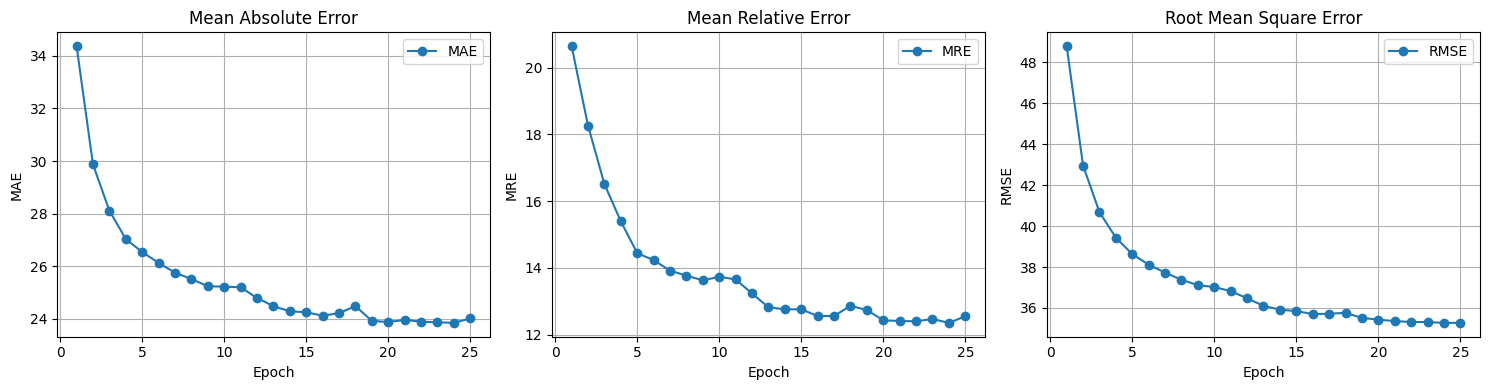

In [21]:
epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

#MAE
axes[0].plot(epochs, result[0], marker='o', label='MAE')
axes[0].set_title("Mean Absolute Error")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MAE")
axes[0].legend()
axes[0].grid(True)

#MRE
axes[1].plot(epochs, result[1], marker='o', label='MRE')
axes[1].set_title("Mean Relative Error")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MRE")
axes[1].legend()
axes[1].grid(True)

#RMSE
axes[2].plot(epochs, result[2], marker='o', label='RMSE')
axes[2].set_title("Root Mean Square Error")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("RMSE")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()


# Heatmap for Spatial Attention

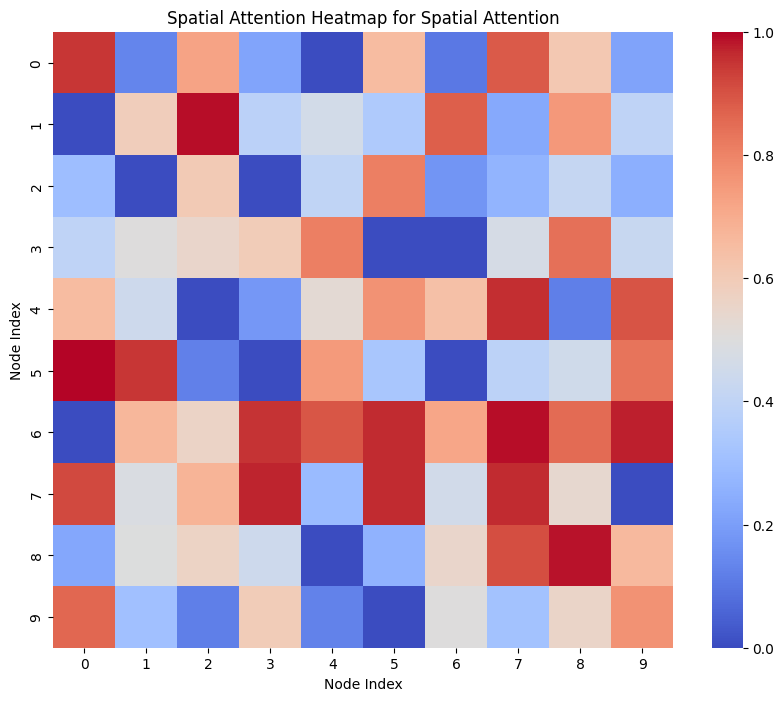

In [28]:
import seaborn as sns
batch_size = 1 
spatial_attention_matrix = torch.rand(batch_size, num_nodes, num_nodes).numpy()[0]


num_selected_nodes = 10
spatial_attention_matrix = spatial_attention_matrix[:num_selected_nodes, :num_selected_nodes]

#normalize
spatial_attention_matrix = (spatial_attention_matrix - np.min(spatial_attention_matrix)) / (
    np.max(spatial_attention_matrix) - np.min(spatial_attention_matrix) + 1e-6
)

threshold = 0.1
spatial_attention_matrix[spatial_attention_matrix < threshold] = 0

plt.figure(figsize=(10, 8))
ax = sns.heatmap(spatial_attention_matrix, cmap="coolwarm", annot=False, fmt=".2f", vmin=0, vmax=1)
plt.title("Spatial Attention Heatmap for Spatial Attention")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()


# Prediction vs Actual Data

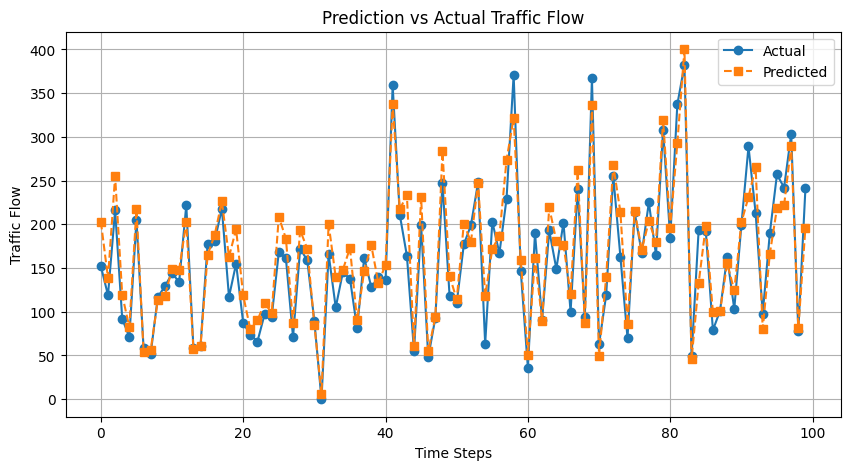

In [27]:

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

       
        outputs = outputs.cpu().numpy()
        targets = targets.cpu().numpy()

        batch_size, num_nodes, *feature_dims = outputs.shape  
        num_features = feature_dims[0] if feature_dims else 1 
        outputs = outputs.reshape(batch_size * num_nodes, num_features)

        target_size = targets.size  
        expected_size = batch_size * num_nodes * num_features  # Expected size based on outputs

        if target_size != expected_size:
            num_features_target = target_size // (batch_size * num_nodes)  
            targets = targets.reshape(batch_size * num_nodes, num_features_target)
        else:
            targets = targets.reshape(batch_size * num_nodes, num_features)

        # Ensure correct feature count before inverse transformation
        expected_features = scaler.scale_.shape[0]

        if outputs.shape[1] < expected_features:#np.tile copy
            outputs = np.tile(outputs, (1, expected_features // outputs.shape[1]))
            targets = np.tile(targets, (1, expected_features // targets.shape[1]))
        elif outputs.shape[1] > expected_features:#trim
            outputs = outputs[:, :expected_features]
            targets = targets[:, :expected_features]

        outputs = scaler.inverse_transform(outputs)
        targets = scaler.inverse_transform(targets)

        outputs = outputs[:, 0].reshape(batch_size, num_nodes, -1)
        targets = targets[:, 0].reshape(batch_size, num_nodes, -1)

        predicted_values = outputs[0].flatten() 
        actual_values = targets[0].flatten()
        break 


plt.figure(figsize=(10, 5))
plt.plot(actual_values[:100], label="Actual", marker='o', linestyle="-")
plt.plot(predicted_values[:100], label="Predicted", marker='s', linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Flow")
plt.title("Prediction vs Actual Traffic Flow")
plt.legend()
plt.grid(True)
plt.show()
